### Contents:

1. Full Bayesian Inference
    1. Fitting the curve
    2. Experimentation with varying values of alpha, beta and degree
2. Bayesian Sequential Learning (Learning point by point)
3. Predictive Distribution (Fitted with uncertainty values)

### Full Bayesian Inference

In [1]:
# Generate function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from numpy.linalg import inv

# Sine curve generation
X_sin = np.arange(0,1,0.02)
Y_sin = np.sin((X_sin**2) +1)

def add_noise(sigma, y_curve):
    mu = 0
    noise = np.random.normal(mu, sigma, len(y_curve))
    y_noise = y_curve + noise
    return y_noise

Y_noise = add_noise(0.05, Y_sin)

In [4]:
# Compute and display w 

def get_w_matrix(x, m, a, b):
    
    X_list = x.tolist()
    X_matrix_list = [1]*(len(X_list))
    
    for i in range(1, m):
        mu = np.linspace(0,1,m)[i]
        
        for j in X_list:
            term = np.exp(-(j-mu)**2/(2*0.1**2))
            X_matrix_list.append(term)
            
    X_matrix_T = np.array(X_matrix_list).reshape(m, len(X_list))
    X_matrix = X_matrix_T.T
    
    w = np.dot(np.dot((b * inv((a * np.identity(m)) + (b * np.dot(X_matrix_T, X_matrix)))), X_matrix_T), Y_noise)
    
    return (w.tolist(), X_matrix)


# Getting Values:
M=5
alpha = 0.1
beta = 10
w_hat = get_w_matrix(X_sin, M, alpha, beta)[0]
print("W has the values:", w_hat)

W has the values: [0.8275646615938622, 0.05330633425716605, 0.11525336211308694, 0.17772835381769536, 0.11558059211018451]


c:\users\katherine\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


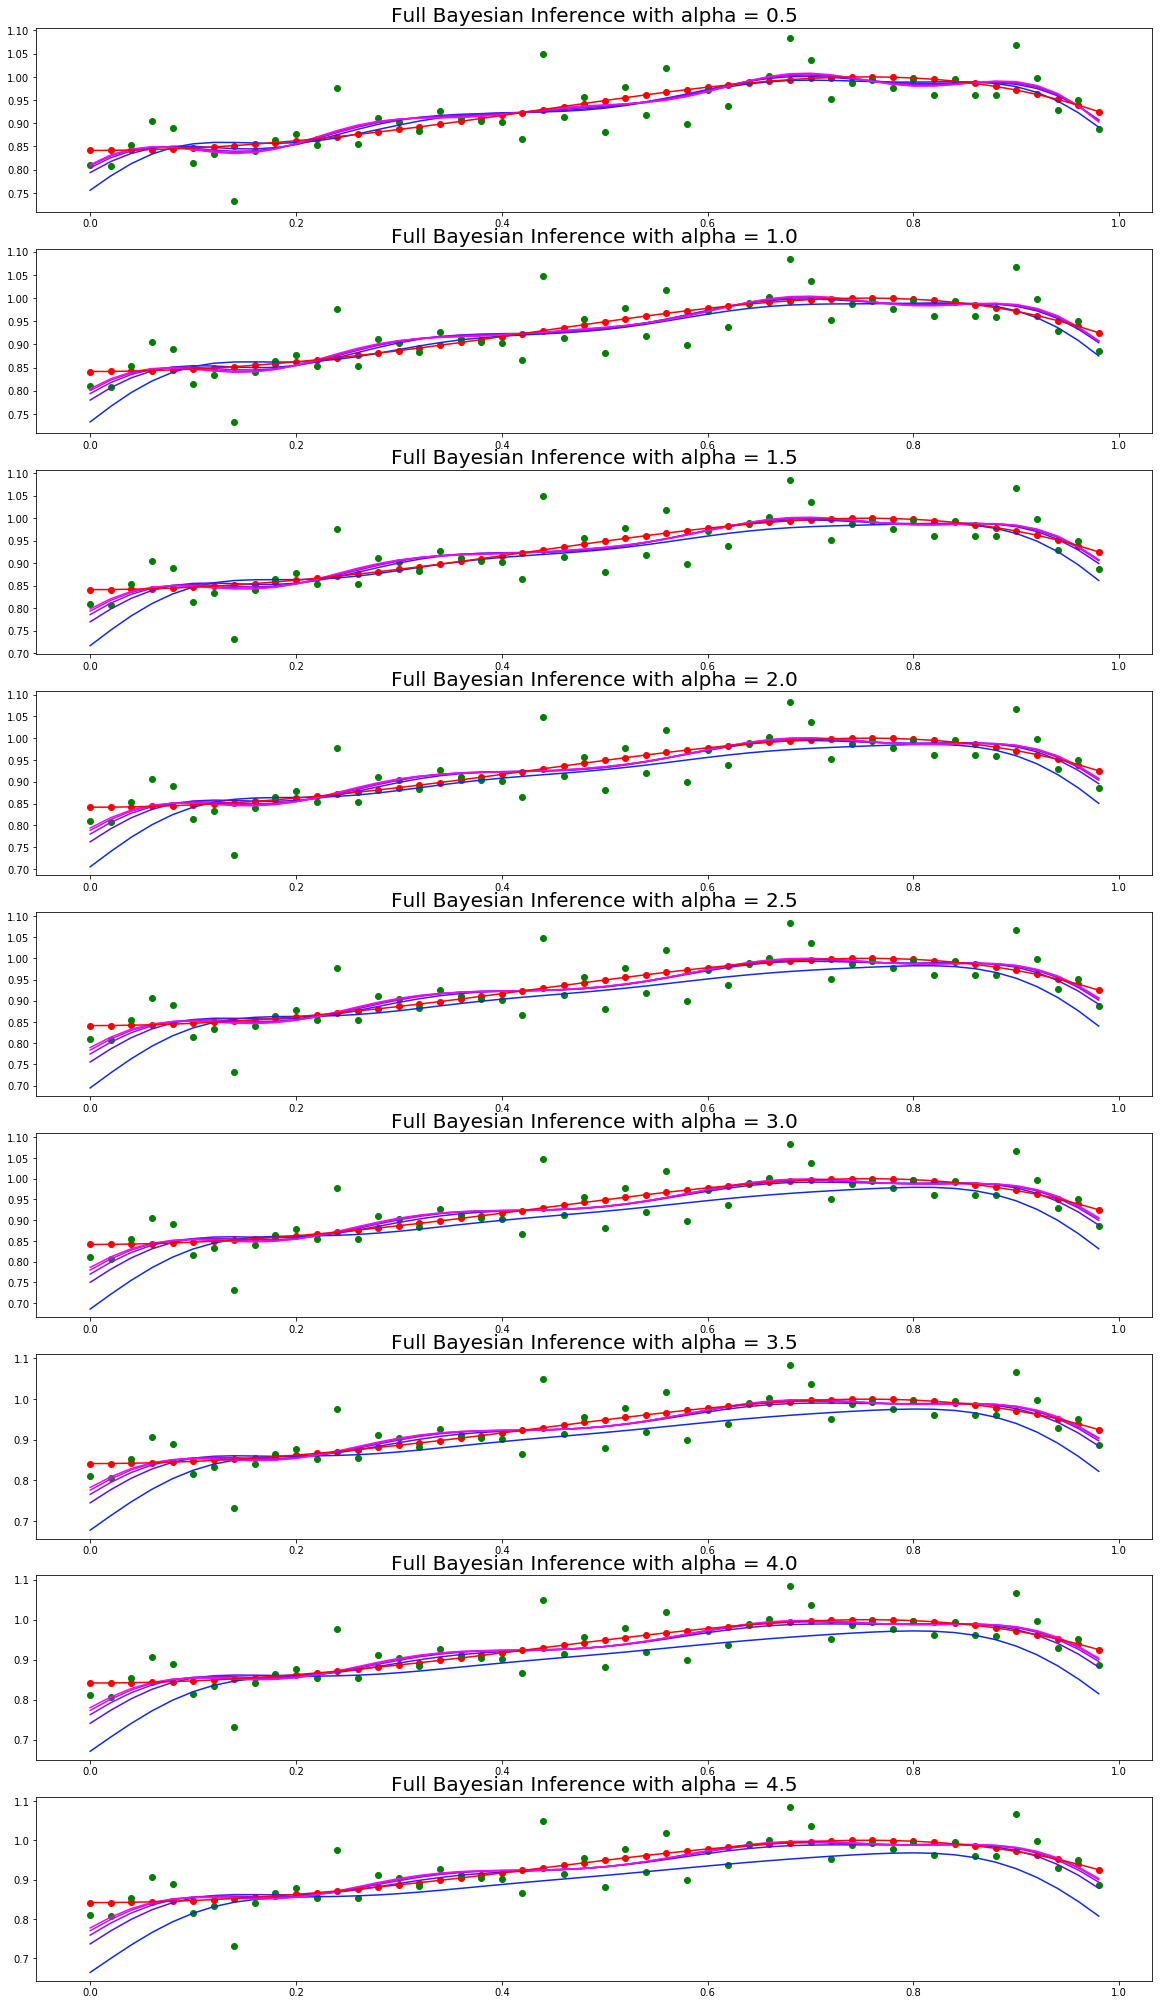

In [5]:
# Changing alpha and beta for varied results

def get_uncertainty(x, m, a, b):
    matrix = get_w_matrix(x, m, a, b)[1]
    uncertainty = inv((a * np.identity(m)) + np.dot((b * matrix.T), matrix))
    return uncertainty

alphas = range(1,10)
betas = [1, 5, 10, 15, 20]
M = 20
uncertainty = []
fig = plt.figure(figsize=(20,40))
color = ['#1079ea','#1029ea','#5810ea','#9210ea','#c910ea','#f409f4']

for i in alphas:
    for j in range(5):
        
        alpha = i/2
        beta = betas[j]
        
        W, matrix = get_w_matrix(X_sin, M, alpha, beta)
        Y_fit = np.dot(matrix, W)
        
        uncertainty.append(get_uncertainty(X_sin, M, alpha, beta))
        
        ax = fig.add_subplot(10,1,i)
        plt.plot(X_sin, Y_fit, c=color[j+1])

    plt.title("Full Bayesian Inference with alpha = {}".format(alpha), fontsize=20)
    plt.scatter(X_sin, Y_sin, c='r')
    plt.plot(X_sin, Y_sin, c='r')
    plt.scatter(X_sin, Y_noise, c='g')

# Comments: Difference might not be obvious using current parameters but I've tried more extreme
# values of alpha and beta and it was clear that the fitted graph started 'ignoring' the data points more 
# as alpha got larger and with larger beta, the graph became less 'wobbly'. 
# alpha is related to the precision while beta is related to the distribution of noise about the fitted line

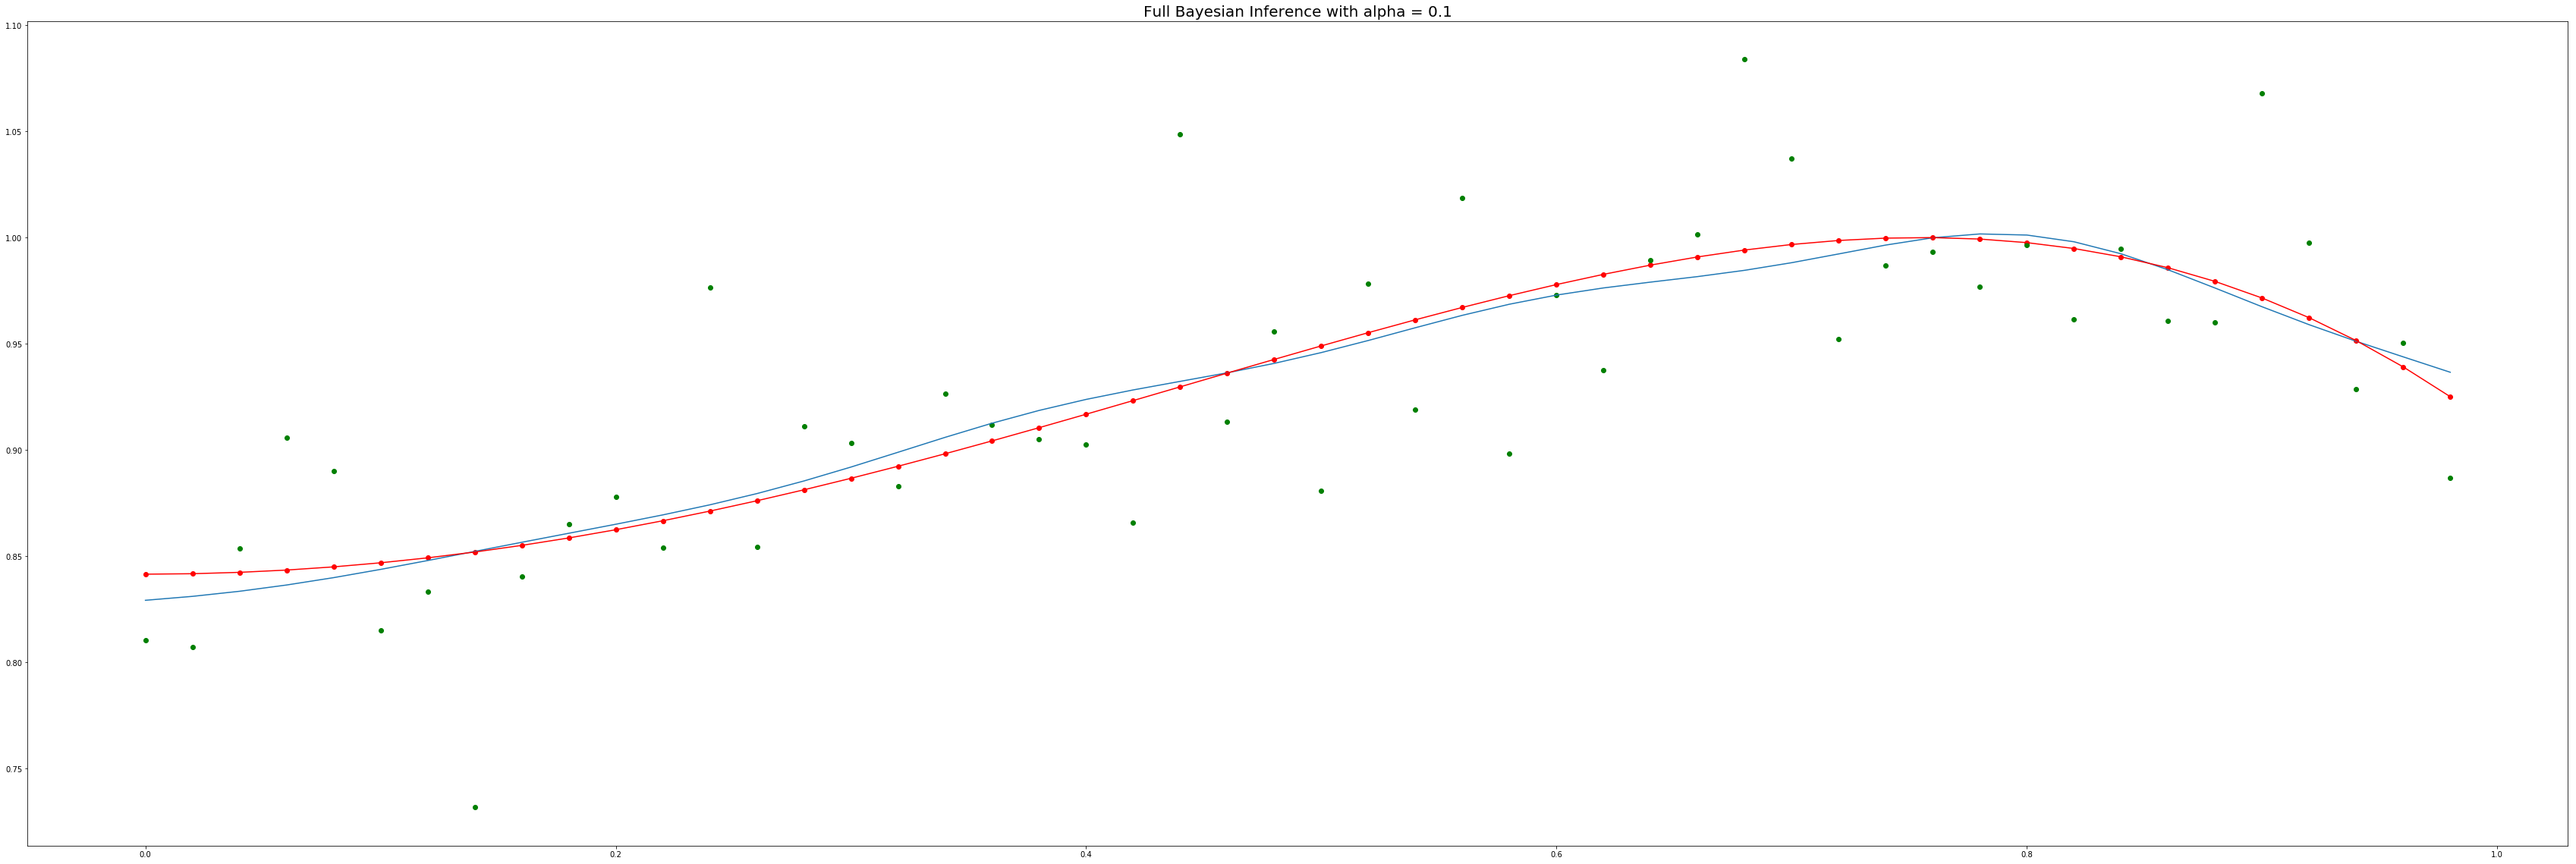

In [6]:
# Show best fitting

alpha = 0.1
beta = 10
M = 6
fig = plt.figure(figsize=(60,20))
W, matrix = get_w_matrix(X_sin, M, alpha, beta)
Y_fit = np.dot(matrix, W)
plt.plot(X_sin, Y_fit)
plt.title("Full Bayesian Inference with alpha = {}".format(alpha), fontsize=20)
plt.scatter(X_sin, Y_sin, c='r')
plt.plot(X_sin, Y_sin, c='r')
plt.scatter(X_sin, Y_noise, c='g')

# Comments: As alpha increases, the fitting of the curve gets a larger variation.
    # As beta increases, the curve gets flatter

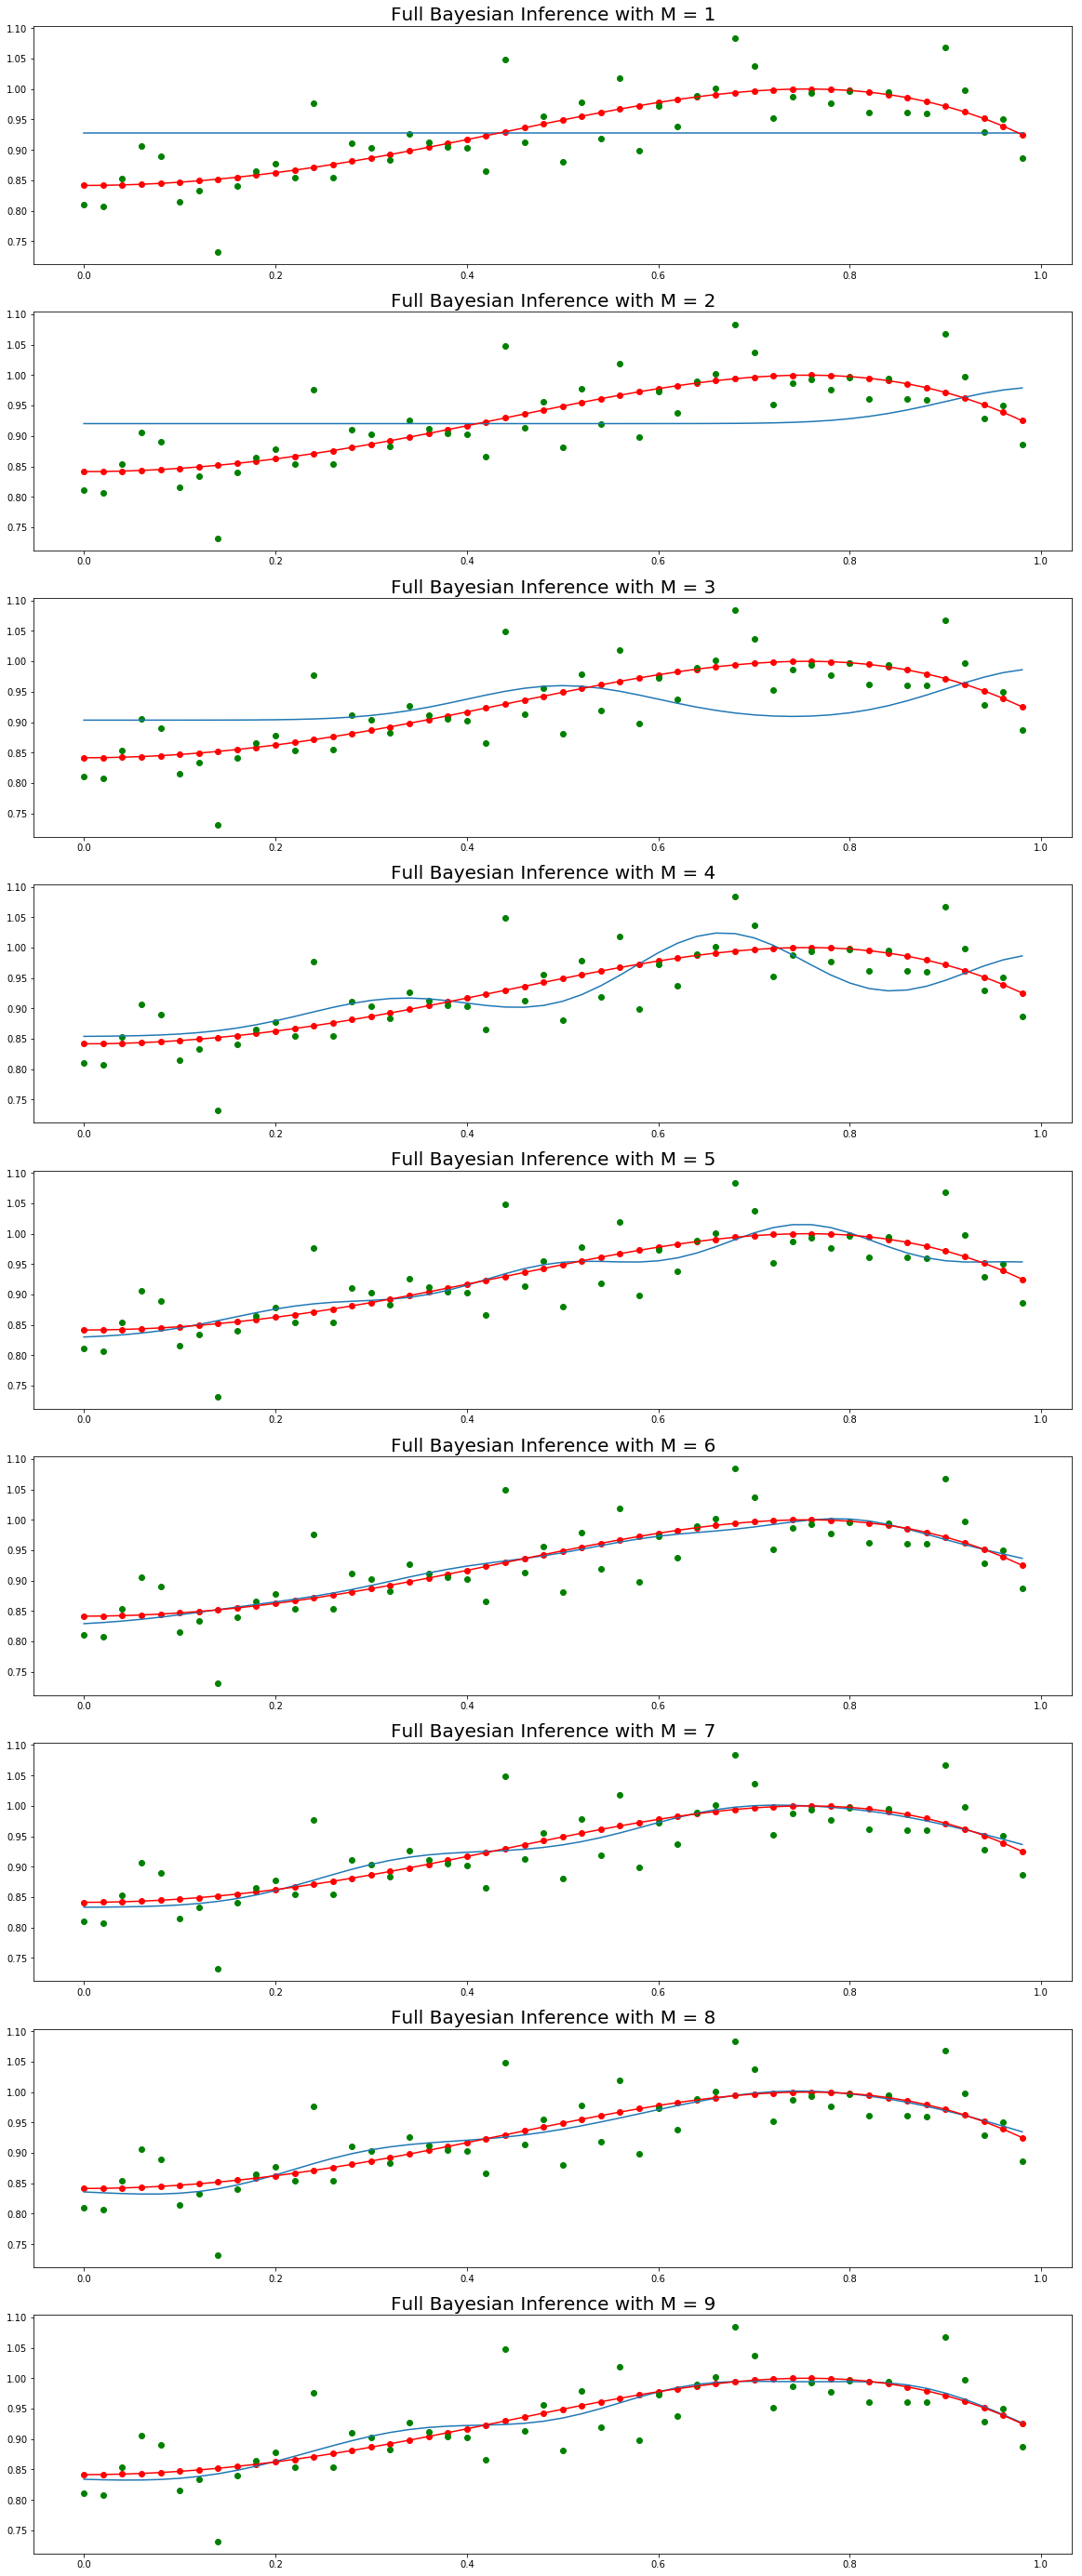

In [7]:
# Change values of M

M_values = range(1,10)
alpha = 0.1
beta = 10
uncertainty = []
fig = plt.figure(figsize=(20,50))

for m in M_values:
    W = get_w_matrix(X_sin, m, alpha, beta)[0]
    Y_fit = np.dot(get_w_matrix(X_sin, m, alpha, beta)[1], W)

    uncertainty.append(get_uncertainty(X_sin, m, 0.1, 0.05))

    ax = fig.add_subplot(9,1,m)
    plt.plot(X_sin, Y_fit)

    plt.title("Full Bayesian Inference with M = {}".format(m), fontsize=20)
    plt.scatter(X_sin, Y_sin, c='r')
    plt.plot(X_sin, Y_sin, c='r')
    plt.scatter(X_sin, Y_noise, c='g')

# Comments: As M increases, as we have seen in the past psets, the curve gets more fitted 
# and for lower values of M, the curve underfits and eventually becomes overfitted as M increases.
# The uncertainty too, decreases and gradually increase with M

In [8]:
# Note: MAP and MLE gave a prediction of w, but we need P(w|t) from full Bayesian inference
# to give the probability P(W|t) to know how likely the parameters are.

### Bayesian Sequential Learning

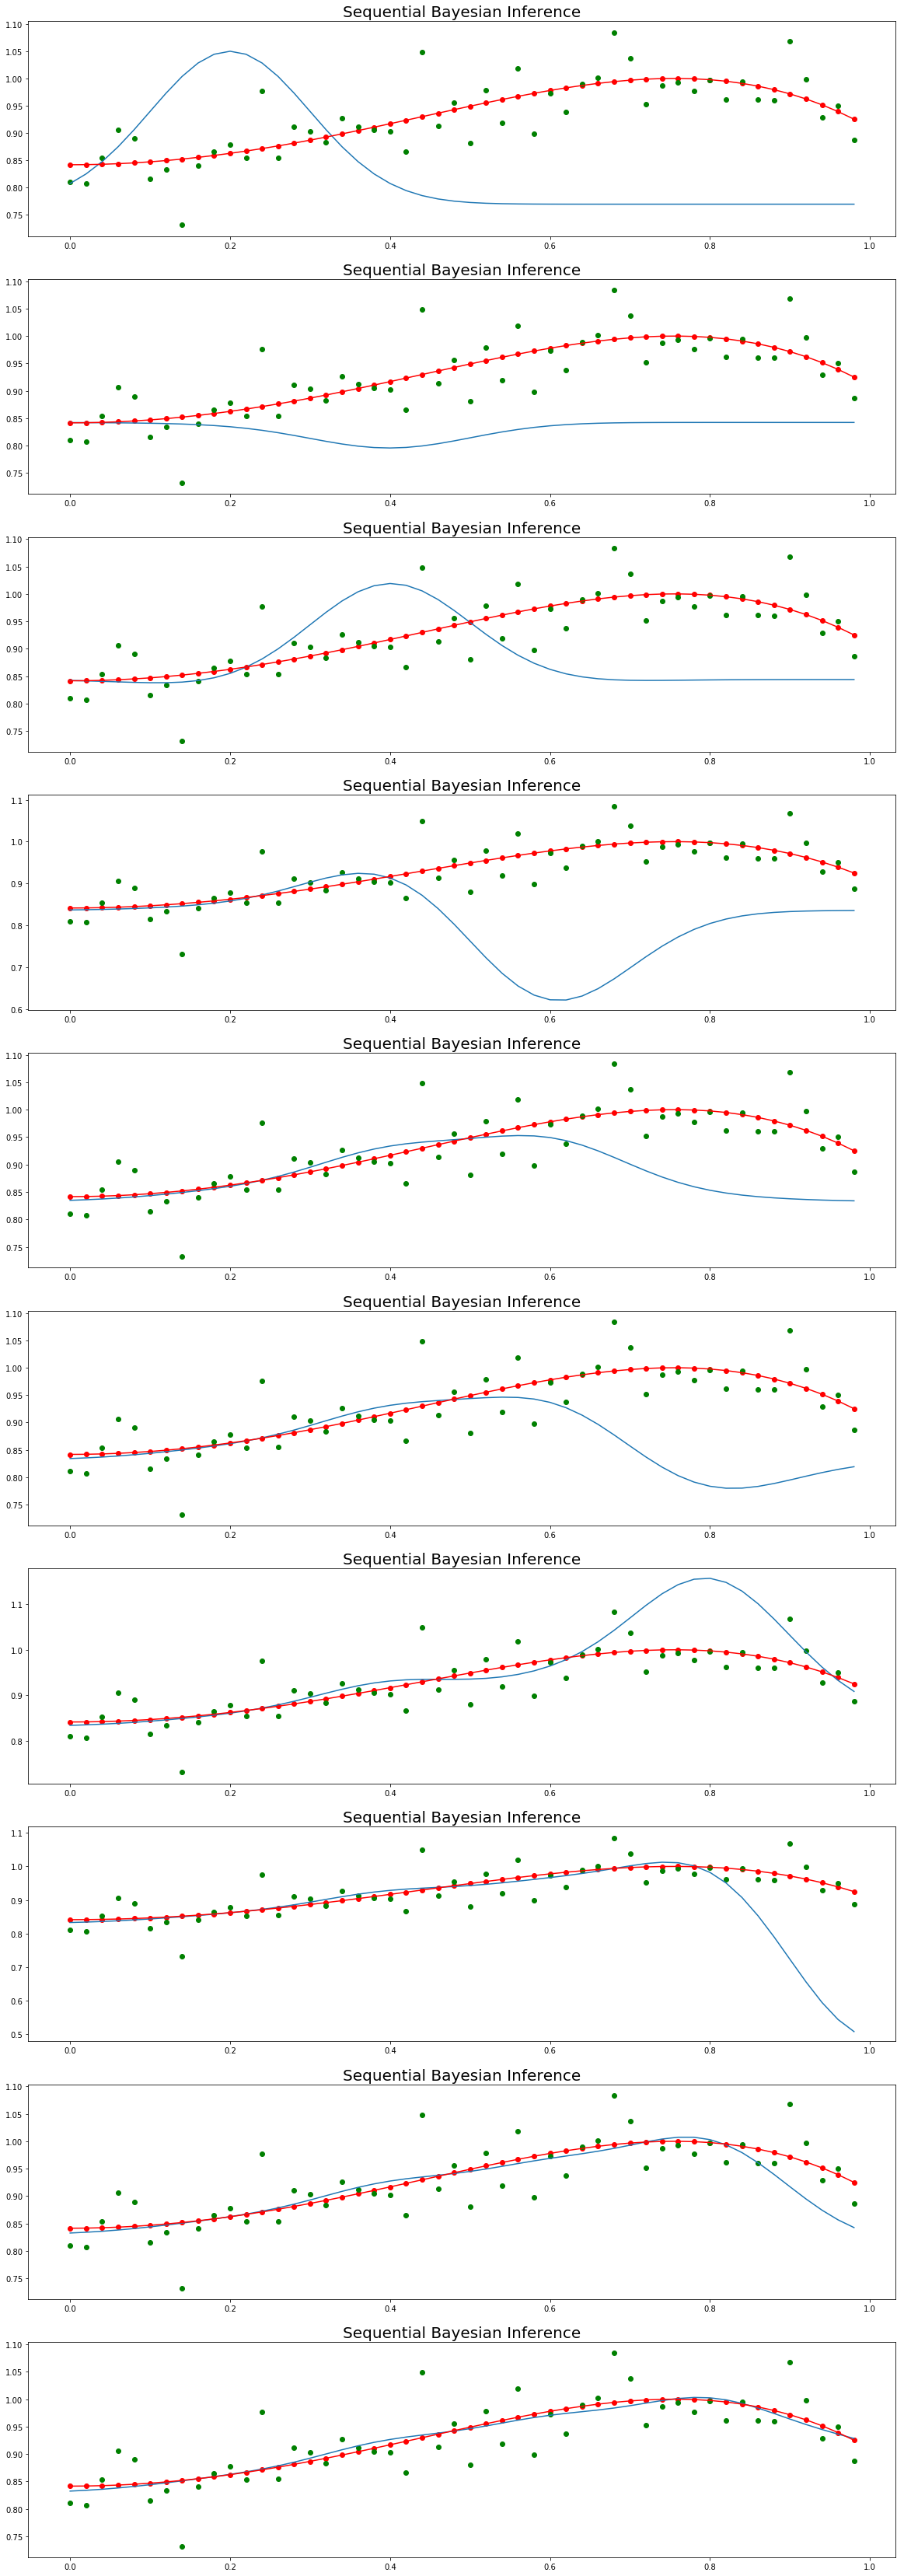

In [9]:
# Fit the noisy data using best(-ish) parameters

M = 6
alpha = 0.1
beta = 10
X_matrix = get_w_matrix(X_sin, M, alpha, beta)[1]
fig = plt.figure(figsize=(20,60))

for batch in range(1,11):
    x = X_sin[:batch*5]
    X_list = x.tolist()
    X_matrix_list = [1]*(len(X_list))
    
    for i in range(1, M):
        mu = np.linspace(0,1,M)[i]
        
        for j in X_list:
            term = np.exp(-(j-mu)**2/(2*0.1**2))
            X_matrix_list.append(term)
    
    matrix = (np.array(X_matrix_list).reshape(M, len(X_list))).T
    
    if batch == 1:
        s = inv((alpha * np.identity(M)) + np.dot((beta * matrix.T), matrix))
        m = np.dot(np.dot((beta * s), matrix.T), Y_noise[:batch*5])
    else:
        s_prev = s
        m_prev = m
        s = inv(inv(s_prev) + np.dot((beta * matrix.T), matrix))
        m = np.dot(np.dot(s, inv(s_prev)), m_prev) + np.dot(np.dot(s, (beta * matrix.T)), Y_noise[:batch*5])
    
    Y_fit = np.dot(get_w_matrix(X_sin, M, alpha, beta)[1], m)
    ax = fig.add_subplot(10,1,batch)
    plt.plot(X_sin, Y_fit)
    plt.title("Sequential Bayesian Inference", fontsize=20)
    plt.scatter(X_sin, Y_sin, c='r')
    plt.plot(X_sin, Y_sin, c='r')
    plt.scatter(X_sin, Y_noise, c='g')
    
# Determined alpha=0.1 beta=10, M=6 to give best(-ish) results for each sequence

###  Predictive Distribution

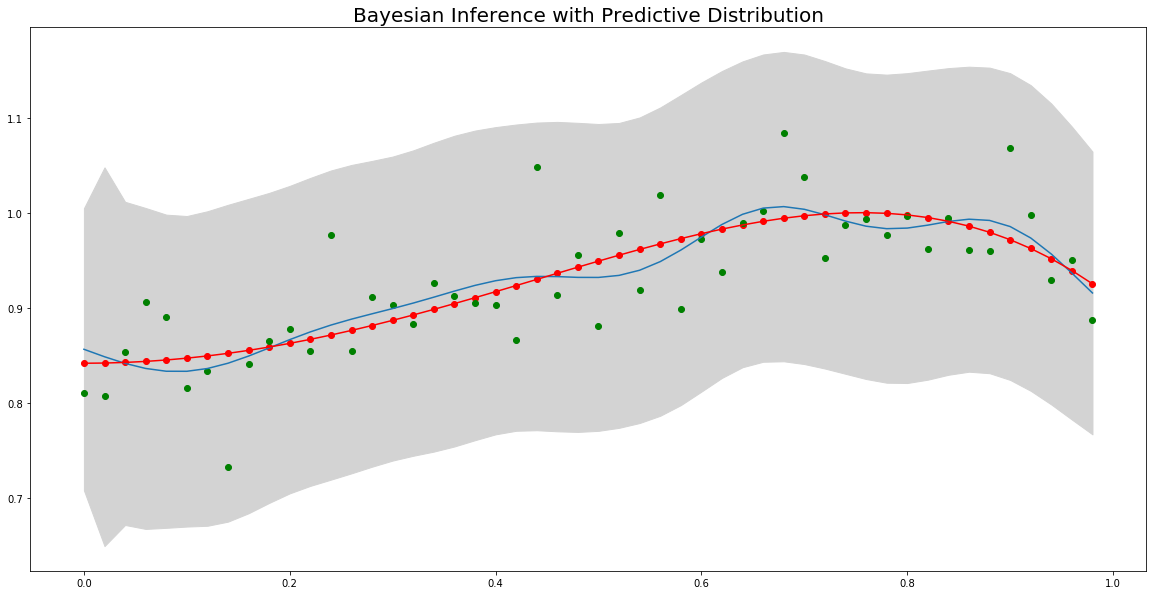

In [96]:
# Sequential predictive distribution

M = 10
alpha = 0.1
beta = 10
uncert = []
X_matrix = get_w_matrix(X_sin, M, alpha, beta)[1]
fig = plt.figure(figsize=(20,10))

for batch in range(0,50):
    x = X_sin[batch]
    X_list = x.tolist()
    X_matrix_list = [1]
    
    for i in range(1, M):
        mu = np.linspace(0,1,M)[i]
        term = np.exp(-(x-mu)**2/(2*0.1**2))
        X_matrix_list.append(term)
    
    matrix = (np.array(X_matrix_list).reshape(M, 1)).T
    
    if batch == 1:
        s = inv((alpha * np.identity(M)) + np.dot((beta * matrix.T), matrix))
        m = np.dot(np.dot((beta * s), matrix.T), Y_noise[batch])
    else:
        s_prev = s
        m_prev = m
        s = inv(inv(s_prev) + np.dot((beta * matrix.T), matrix))
        m = np.dot(np.dot(s, inv(s_prev)), m_prev) + np.dot(np.dot(s, (beta * matrix.T)), Y_noise[batch])
    
    uncert.append(float((1/beta) + np.dot(np.dot(matrix, s), matrix.T)))

Y_fit = np.dot(get_w_matrix(X_sin, M, alpha, beta)[1], m)
plt.fill_between(X_sin, np.array([i[0] for i in Y_fit]) - np.array(uncert), 
                 np.array([i[0] for i in Y_fit]) + np.array(uncert), color= 'lightgrey')
plt.plot(X_sin, Y_fit)
plt.title("Bayesian Inference with Predictive Distribution", fontsize=20)
plt.scatter(X_sin, Y_sin, c='r')
plt.plot(X_sin, Y_sin, c='r')
plt.scatter(X_sin, Y_noise, c='g')


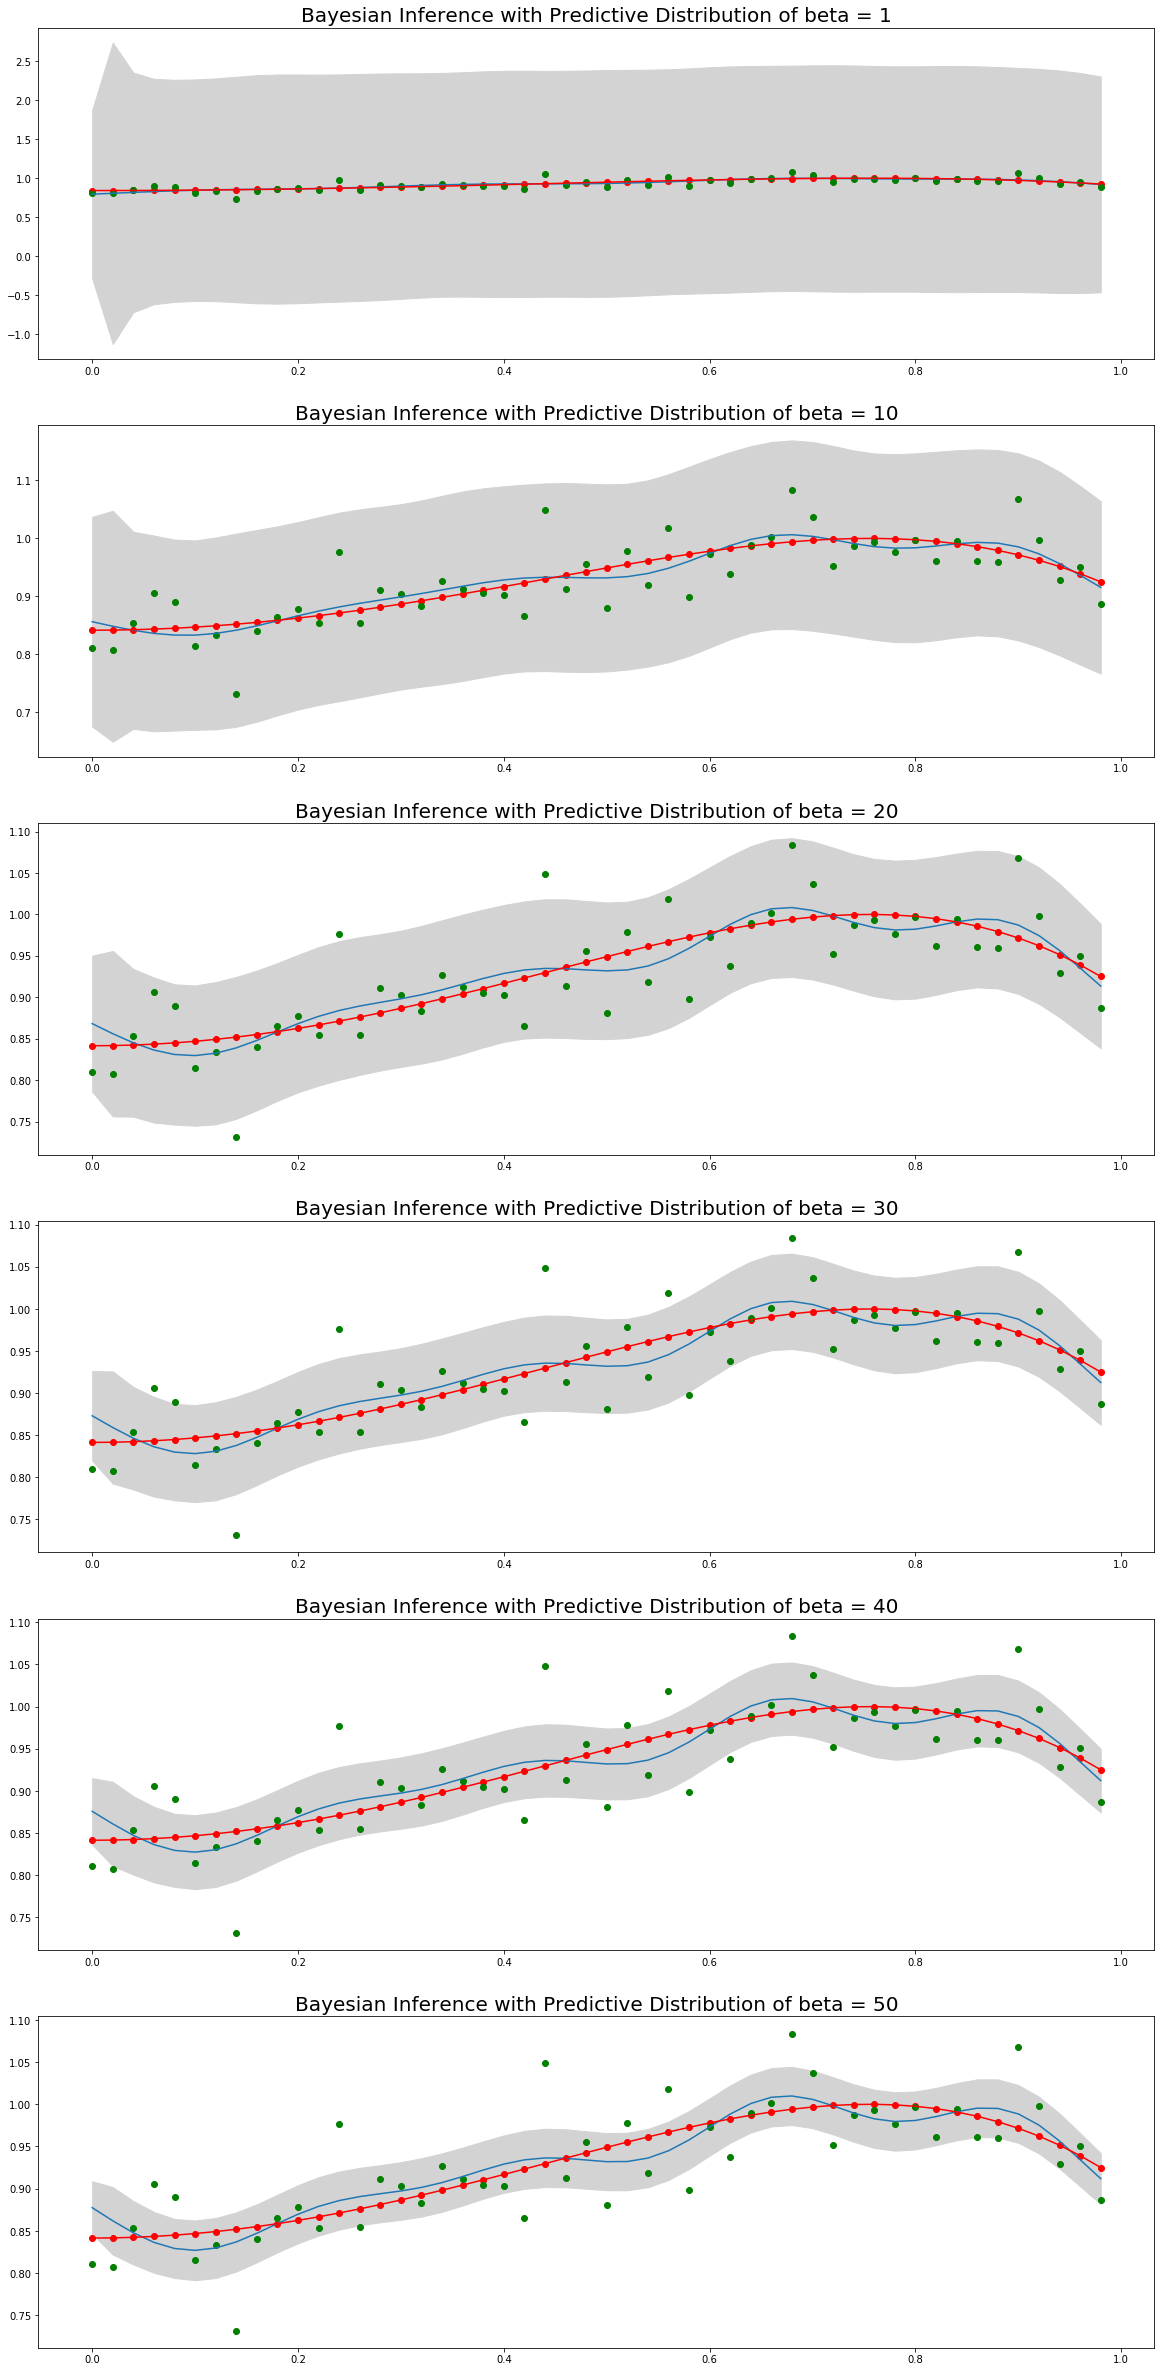

In [97]:
# Changing beta 

M = 10
alpha = 0.1
betas = [1, 10, 20, 30, 40, 50]
X_matrix = get_w_matrix(X_sin, M, alpha, beta)[1]
fig = plt.figure(figsize=(20,50))

for each_round in range(len(betas)):
    
    uncert = []
    beta = betas[each_round]
    
    for batch in range(0,50):
        x = X_sin[batch]
        X_list = x.tolist()
        X_matrix_list = [1]

        for i in range(1, M):
            mu = np.linspace(0,1,M)[i]
            term = np.exp(-(x-mu)**2/(2*0.1**2))
            X_matrix_list.append(term)

        matrix = (np.array(X_matrix_list).reshape(M, 1)).T

        if batch == 1:
            s = inv((alpha * np.identity(M)) + np.dot((beta * matrix.T), matrix))
            m = np.dot(np.dot((beta * s), matrix.T), Y_noise[batch])
        else:
            s_prev = s
            m_prev = m
            s = inv(inv(s_prev) + np.dot((beta * matrix.T), matrix))
            m = np.dot(np.dot(s, inv(s_prev)), m_prev) + np.dot(np.dot(s, (beta * matrix.T)), Y_noise[batch])

        uncert.append(float((1/beta) + np.dot(np.dot(matrix, s), matrix.T)))

    ax = fig.add_subplot(7,1,each_round+1)
    Y_fit = np.dot(get_w_matrix(X_sin, M, alpha, beta)[1], m)
    plt.plot(X_sin, Y_fit)
    plt.fill_between(X_sin, np.array([i[0] for i in Y_fit]) - np.array(uncert), 
                     np.array([i[0] for i in Y_fit]) + np.array(uncert), color= 'lightgrey')
    plt.title("Bayesian Inference with Predictive Distribution of beta = " + str(beta), fontsize=20)
    plt.scatter(X_sin, Y_sin, c='r')
    plt.plot(X_sin, Y_sin, c='r')
    plt.scatter(X_sin, Y_noise, c='g')

# As mentioned above, beta is related to the distribution of noise around the fitted graph. 
# Hence having a larger beta results in a smaller s* (since they are inversely related) as shown below.

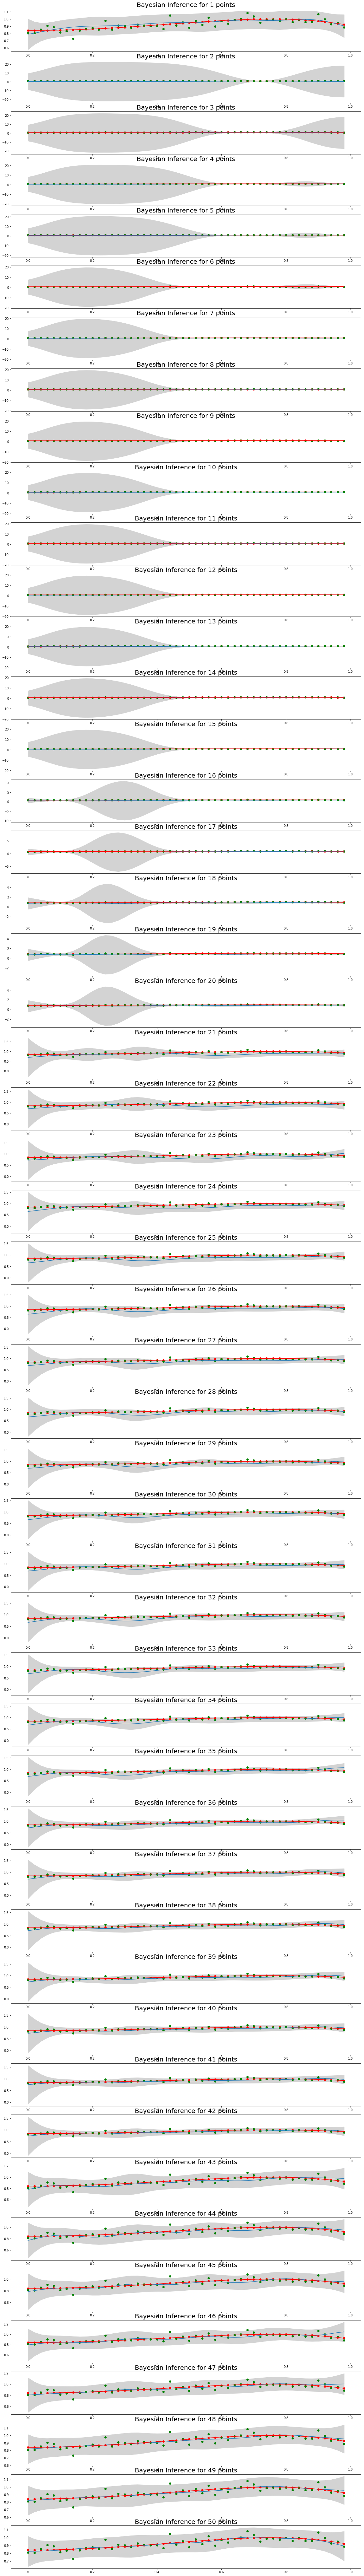

In [95]:
# Show best prediction for all 50 data
from random import randint

M = 10
alpha = 0.1
beta = 10
x_batch_index = []
X_matrix = get_w_matrix(X_sin, M, alpha, beta)[1]
fig = plt.figure(figsize=(20,150))

for pred_round in range(50):
    x_batch_index.append(randint(0,49))
    x_batch = [X_sin[i] for i in x_batch_index]
    x_batch.sort()
    uncert = []

    for batch in range(len(x_batch)):
        x = x_batch[batch]
        X_list = x.tolist()
        X_matrix_list = [1]

        for i in range(1, M):
            mu = np.linspace(0,1,M)[i]
            term = np.exp(-(x-mu)**2/(2*0.1**2))
            X_matrix_list.append(term)

        matrix = (np.array(X_matrix_list).reshape(M, 1)).T

        if batch == 1:
            s = inv((alpha * np.identity(M)) + np.dot((beta * matrix.T), matrix))
            m = np.dot(np.dot((beta * s), matrix.T), Y_noise[batch])
        else:
            s_prev = s
            m_prev = m
            s = inv(inv(s_prev) + np.dot((beta * matrix.T), matrix))
            m = np.dot(np.dot(s, inv(s_prev)), m_prev) + np.dot(np.dot(s, (beta * matrix.T)), Y_noise[batch])

    for point in range(0,50):
        x = X_sin[point]
        X_list = x.tolist()
        X_matrix_list = [1]

        for i in range(1, M):
            mu = np.linspace(0,1,M)[i]
            term = np.exp(-(x-mu)**2/(2*0.1**2))
            X_matrix_list.append(term)

        matrix = (np.array(X_matrix_list).reshape(M, 1)).T
        uncert.append(float((1/beta) + np.dot(np.dot(matrix, s), matrix.T)))

    Y_fit = np.dot(get_w_matrix(X_sin, M, alpha, beta)[1], m)
    ax = fig.add_subplot(50,1, pred_round+1)
    plt.fill_between(X_sin, np.array([i[0] for i in Y_fit]) - np.array(uncert), 
                     np.array([i[0] for i in Y_fit]) + np.array(uncert), color= 'lightgrey')
    plt.plot(X_sin, Y_fit)
    plt.title("Bayesian Inference for "+ str(pred_round+1) +" points", fontsize=20)
    plt.scatter(X_sin, Y_sin, c='r')
    plt.plot(X_sin, Y_sin, c='r')
    plt.scatter(X_sin, Y_noise, c='g')


### Note:
 Unlike full Bayesian inference, predictive distribution shows us a distribution for future values given data we already have. Hence, we can extrapolate/intrapolate the prediction of t and the uncertainty of the prediction.

### Note: Difference between p(t_new|t) and p(w|t)
P(t_new|t) is interested in estimating the y value of the new x values given. With respect to w, the parameters, we know that P(t_new|t) is the integrated product of P(t*|w), P(w|t). Where in sequential learning, the posterior of the previous data points becomes now the prior of the next computation, similarly for P(w|t), it becomes the Gaussian prior of P(t_new|t) with respect to w.